# Correcting the daily testcount prediction with known week totals

Because the daily testcount data for germany is not publicly available I'm going to use the Belgian data instead of the german data to show the method.

In [1]:
# this cell makes it easier to mess with the project code interactively
%load_ext autoreload
%autoreload 2

In [2]:
import datetime
import logging
import numpy
import pandas
import pathlib
import matplotlib
from matplotlib import pyplot, cm

import arviz
import pymc3

_log = logging.getLogger('notebook')
logging.basicConfig(level=logging.INFO)

# messing with the path to get imports working
import sys
sys.path.append(str(pathlib.Path("..").resolve()))

import rtlive
from rtlive import data, preprocessing

ERROR:fbprophet.plot:Importing plotly failed. Interactive plots will not work.


## Getting the Data

In [3]:
from rtlive.sources import ourworldindata, data_de, data_be

In [4]:
run_time = pandas.Timestamp.today()
oiwd_data = ourworldindata.download_owid(run_time)

In [5]:
df_be_total_tests = oiwd_data.xs('BE').xs('all').total_tests
df_be_daily_tests = df_be_total_tests.diff()

In [6]:
df_be_weekly_total_tests = df_be_total_tests.resample('W-Sun', level='date').last() #XXX: I don't know if the german data reported for sunday does include the data for sunday itself.
df_be_weekly_total_tests.drop(df_be_weekly_total_tests.tail(1).index,inplace=True) #Remove last row, because its an incomplete week in the future

Simulate the current data situation for germany: Daily data until approx. 2020-12-07, weekly data until 2020-12-27

In [7]:
end_of_daily_data = pandas.Timestamp('2020-12-07')
end_of_weekly_data = pandas.Timestamp('2020-12-27')

In [8]:
df_be_daily_tests_cropped = df_be_total_tests.diff()
df_be_daily_tests_cropped.loc[end_of_daily_data:] = numpy.nan

df_be_weekly_total_tests_cropped = df_be_weekly_total_tests.copy()
df_be_weekly_total_tests_cropped[end_of_weekly_data:] = numpy.nan

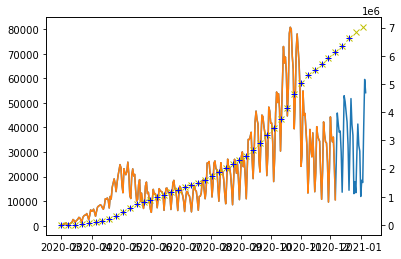

In [9]:
fig, ax1 = pyplot.subplots()
ax1.plot(df_be_daily_tests)
ax1.plot(df_be_daily_tests_cropped)

ax2 = ax1.twinx()
ax2.plot(df_be_weekly_total_tests, 'yx')
ax2.plot(df_be_weekly_total_tests_cropped, 'b+')

## First Prediction

In [10]:
kwargs = dict(
                keep_data=True,
                growth="linear",
                ignore_before=pandas.Timestamp("2020-03-15") #XXX: In the original code there was a max:
                #max(
                    #pandas.Timestamp("2020-03-15"),
                    #df.xs(region)[~new_tests_nans].reset_index().date[0], #XXX
                #),
            )
result_be_daily_tests = preprocessing.predict_testcounts(df_be_daily_tests_cropped, country='DE', region='all', **kwargs)
result_df_be_daily_tests = result_be_daily_tests[0]

(18589.0, 18650.6)

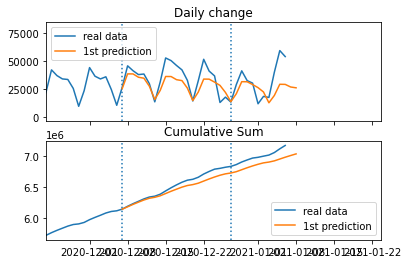

In [17]:
plotstart = end_of_daily_data - pandas.Timedelta('2W')
fig, axs = pyplot.subplots(2,sharex=True)
axs[0].set_title("Daily change")
axs[0].axvline(end_of_daily_data,linestyle="dotted")
axs[0].axvline(end_of_weekly_data,linestyle="dotted")
axs[0].plot(df_be_daily_tests,label="real data")
axs[0].plot(result_df_be_daily_tests[end_of_daily_data:], label = "1st prediction")
axs[0].legend()
axs[1].set_title("Cumulative Sum")
axs[1].axvline(end_of_daily_data,linestyle="dotted")
axs[1].axvline(end_of_weekly_data,linestyle="dotted")
axs[1].plot(df_be_daily_tests.cumsum()[plotstart:],label="real data")
axs[1].plot(result_df_be_daily_tests.cumsum()[end_of_daily_data:], label = "1st prediction")
axs[1].legend()
pyplot.xlim(plotstart)

## Correcting Prediction with known week data

In [12]:
result_df_be_daily_tests_corrected = result_df_be_daily_tests.copy()
df_be_weekly_tests_cropped = df_be_weekly_total_tests_cropped.diff()
week = pandas.Timedelta('6D') #Because the ranges in panda are inclusive, so we don't accidentally update a value twice
for date,weeksum in df_be_weekly_tests_cropped[end_of_daily_data:].items():
    if numpy.isnan(weeksum):
        print("skipping", date-week, date)
        break;
    result_df_be_daily_tests_corrected[date - week:date] *= weeksum/result_df_be_daily_tests[date - week:date].sum()
    print(date - week, date, weeksum, result_df_be_daily_tests[date - week:date].sum(), result_df_be_daily_tests_corrected[date - week:date].sum())

2020-12-07 00:00:00 2020-12-13 00:00:00 234166.0 216576.59005811057 234165.99999999994
2020-12-14 00:00:00 2020-12-20 00:00:00 270724.0 203348.4527808876 270724.0
skipping 2020-12-21 00:00:00 2020-12-27 00:00:00


(18589.0, 18650.6)

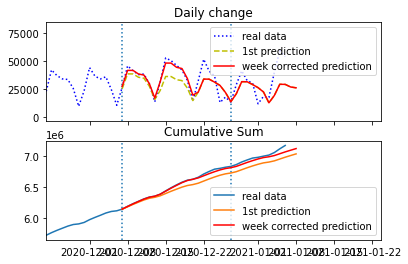

In [13]:
fig, axs = pyplot.subplots(2,sharex=True)
axs[0].axvline(end_of_daily_data,linestyle="dotted")
axs[0].axvline(end_of_weekly_data,linestyle="dotted")
axs[0].set_title("Daily change")
axs[0].plot(df_be_daily_tests, 'b:', label="real data")
axs[0].plot(result_df_be_daily_tests[end_of_daily_data:], "y--",  label = "1st prediction")
axs[0].plot(result_df_be_daily_tests_corrected[end_of_daily_data:], "r-", label="week corrected prediction")
axs[0].legend()
axs[1].set_title("Cumulative Sum")
axs[1].axvline(end_of_daily_data,linestyle="dotted")
axs[1].axvline(end_of_weekly_data,linestyle="dotted")
axs[1].plot(df_be_daily_tests.cumsum()[plotstart:],label="real data")
axs[1].plot(result_df_be_daily_tests.cumsum()[end_of_daily_data:], label = "1st prediction")
axs[1].plot(result_df_be_daily_tests_corrected.cumsum()[end_of_daily_data:], "r-", label="week corrected prediction")
axs[1].legend()
pyplot.xlim(plotstart)


## Do another prediction on the week-corrected data

In [14]:
kwargs = dict(
                keep_data=True,
                growth="linear",
                ignore_before=pandas.Timestamp("2020-03-15") #XXX: In the original code there was a max:
                #max(
                    #pandas.Timestamp("2020-03-15"),
                    #df.xs(region)[~new_tests_nans].reset_index().date[0], #XXX
                #),
            )
result_be_daily_tests_corrected_repredict = preprocessing.predict_testcounts(result_df_be_daily_tests_corrected, country='DE', region='all', **kwargs)
result_df_be_daily_tests_corrected_repredict = result_be_daily_tests_corrected_repredict[0]

(18589.0, 18650.6)

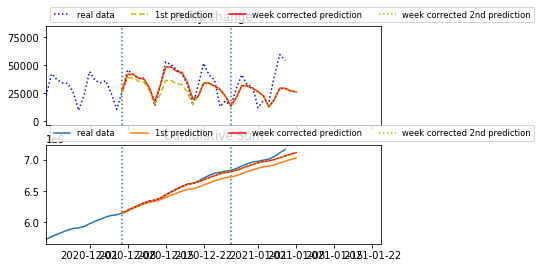

In [15]:
fig, axs = pyplot.subplots(2,sharex=True)
axs[0].axvline(end_of_daily_data,linestyle="dotted")
axs[0].axvline(end_of_weekly_data,linestyle="dotted")
axs[0].set_title("Daily change")
axs[0].plot(df_be_daily_tests, 'b:', label="real data")
axs[0].plot(result_df_be_daily_tests[end_of_daily_data:], "y--",  label = "1st prediction")
axs[0].plot(result_df_be_daily_tests_corrected[end_of_daily_data:], "r-", label="week corrected prediction")
axs[0].plot(result_df_be_daily_tests_corrected_repredict[end_of_daily_data:], "y:", label="week corrected 2nd prediction")
axs[0].legend(ncol=4,bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')
axs[1].set_title("Cumulative Sum")
axs[1].axvline(end_of_daily_data,linestyle="dotted")
axs[1].axvline(end_of_weekly_data,linestyle="dotted")
axs[1].plot(df_be_daily_tests.cumsum()[plotstart:],label="real data")
axs[1].plot(result_df_be_daily_tests.cumsum()[end_of_daily_data:], label = "1st prediction")
axs[1].plot(result_df_be_daily_tests_corrected.cumsum()[end_of_daily_data:], "r-", label="week corrected prediction")
axs[1].plot(result_df_be_daily_tests_corrected_repredict.cumsum()[end_of_daily_data:], "y:", label="week corrected 2nd prediction")
axs[1].legend(ncol=4,bbox_to_anchor=(0, 1), loc='lower left', fontsize='small')
pyplot.xlim(plotstart)

This second prediction did not seem to improve the result any further